# Retail Vision Analytics Notebook


This notebook intends to produce analytics based on data obtained from video analysis. These analytics can assist businesses in understanding customer behavior and making data-driven decisions. Video analysis utilized advanced Computer Vision algorithms in object detection and tracking. 

The potential for analytics is vast, but this notebook aims to demonstrate a few examples, such as:

(1) Mapping customer movement to physical locations

(2) Visualizing customer timelines

(3) Exploring other potential analytics

## 1. Maps

Mapping customer movement within the field of view is a valuable tool for businesses as it allows them to understand where customers spend their time and where they are not. Maps help store owners make informed decisions about store layout and product placement. 

The mapping was conducted using heatmaps, visually representing customer density in different store areas. The map allows store owners to quickly identify hotspots and cold spots within their store, helping them optimize their space and increase customer satisfaction. Density values represent the percent of customers' total time in one of sixteen areas. 

Additionally, this information can improve customer experience by identifying areas of the store that may need more staff or attention. Understanding customer movement patterns can also help store owners identify potential bottlenecks or areas that need improvement to increase efficiency.


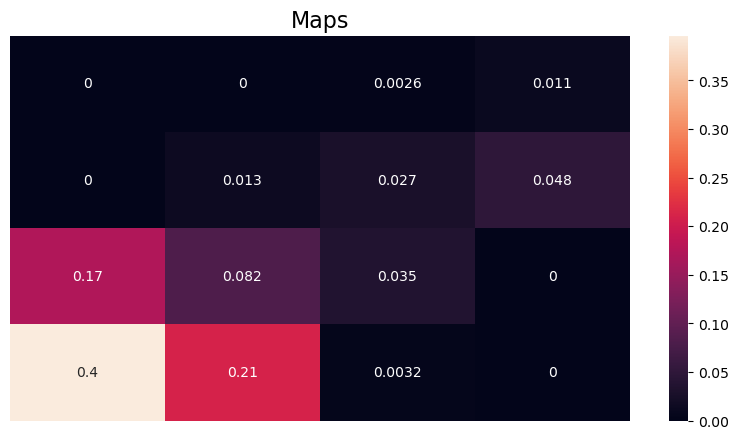

In [9]:
# Import seaborn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Set constants
FILENAME = 'results.txt'
BINS = 4

# Create a dataframe from the tracking data
df = pd.read_csv(FILENAME, \
                 names=['frame', 'customer', 'x1', 'y1', 'width', 'height', 'conf', 'x', 'y', 'z']).\
                 drop(['x', 'y', 'z'], axis=1)

# Calculate the centers for x & y for each bounding box
df['x_ctr'] = (df['x1'] + 0.5*df['width'])
df['y_ctr'] = (df['y1'] + 0.5*df['height'])
df.sort_values(by=['frame', 'customer'], inplace=True)

# Create an x and y dataset from the calculated centers for x & y in the dataframe
x = df[['x_ctr']].values.astype(int)[:,0]
y = df[['y_ctr']].values.astype(int)[:,0]
            
# Create the heatmap variables
# Use a histogram to bin the location data
heatmap, xedges, yedges = np.histogram2d(x, y, bins=BINS)
heatmap = heatmap/heatmap.sum()

# Build and show the heatmap
fig, ax = plt.subplots(figsize=(10, 5)) 
ax = sns.heatmap(heatmap, \
                 xticklabels=False, yticklabels=False, \
                annot=True)
ax.invert_xaxis()
ax.set_title('Maps', fontsize=16)
ax.invert_yaxis()
plt.show()

## 2. Timelines


Creating timelines for individual customers is another vital aspect of understanding customer behavior. Timelines allow store owners to see the flow of customers throughout the day and identify patterns in their behavior. In this example, we create horizontal bar charts that show the time a customer arrives and leaves relative to other customers. These analytics helps store owners identify peak hours and slow periods, which can inform staffing and inventory decisions.

We exclude customers detected for less than 10 seconds because such customers may have left the store or been false detections. These exclusions help store owners make better decisions based on reliable data. 

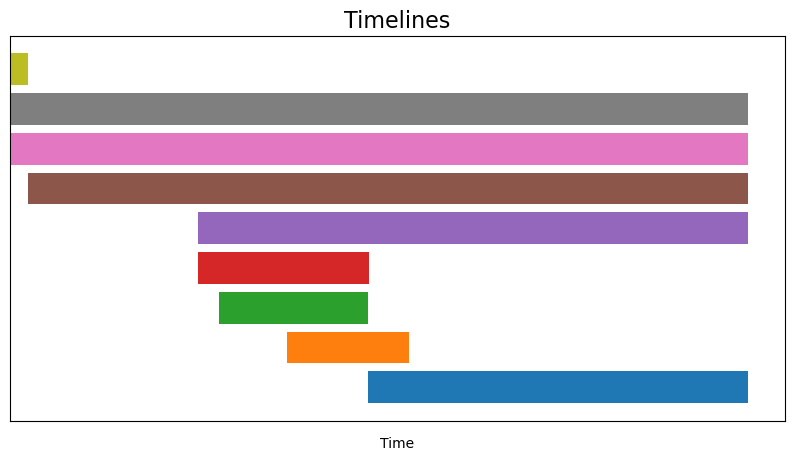

In [10]:
# Specify a CONSTANT for the minimum number of frames for analyzing customer
MIN_FRAMES = 30

# Create variables to store data that the df needs
customers = []
starts = []
durations = []

for c in df.customer.unique():
    # Create a variable and load with the id, start frame, and frame duration for each customer
    customer = df.customer.unique()
    start = df[df.customer==c].frame.min()
    duration = df[df.customer==c].frame.max() - df[df.customer==c].frame.min()
    
    # Add the captured data to the array if duration was greater than MIN_FRAMES frames
    if duration >= MIN_FRAMES:
        customers.append(c)
        starts.append(start)
        durations.append(duration)
        
fig, ax = plt.subplots(figsize=(10,5))

customer_ids = ['Customer ' + str(c) for c in customers]

# Reverse the lists so it plots sequentially top to bottom
customer_ids.reverse()
durations.reverse()
starts.reverse()

# Use a colormap for assigning colors to bars
cmap = plt.cm.tab10
colors = cmap(np.arange(len(df)) % cmap.N)

# Plot the customer info
ax.set_title('Timelines', fontsize=16)
ax.set(xlabel='Time')
ax.set(xticklabels=[])
ax.tick_params(bottom=False)
ax.set(yticklabels=[])
ax.set(ylabel='')
ax.tick_params(left=False)
ax.barh(customer_ids, durations, left=starts, color=colors)

plt.show()

## 3. Other analytics

Below are additional analytics that provides valuable insights for store owners.

1) A time plot of the total customers in the store that identifies peak hours and slow periods would help make better staffing decisions and schedules. 

2) A safety alert could be triggered when customers have fallen or laid down. The customer may have fallen if the bounding box's width exceeds the height. 

3) Distance and speed metrics can be calculated to identify fast and slow customers. Customer speed can inform product placement and store layout decisions. 


It's worth noting that these are just a few more examples of the countless analytics possible from our video analysis. 

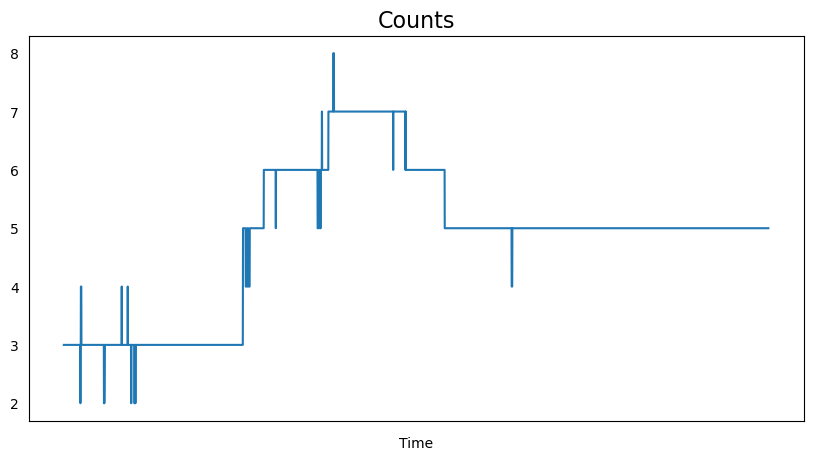

In [11]:
# Create a variable with customer counts by frame
customers = df.groupby('frame')['frame'].count().values

# Build and show the lineplot
fig, ax = plt.subplots(figsize=(10, 5)) 
ax = sns.lineplot(data=customers)
ax.set_title('Counts', fontsize=16)
ax.set(xlabel='Time')
ax.set(xticklabels=[])
ax.tick_params(bottom=False)
ax.set(ylabel='')
ax.tick_params(left=False)
plt.show()

In [12]:
# Person down alerts - was anyone vertical?
frames_down = df.query('width > height').count()[0]
print('%d FALL ALERTs\n\n' % frames_down)

0 FALL ALERTs




In [13]:
# Create a list of the unique ids
customers = df.customer.unique()

# Create variables to store data that the df needs
total_frames = []
total_distance = []

for c in customers:
    # Find the first and last frame
    first_frame = df[df.customer==c].frame.min()
    last_frame = df[df.customer==c].frame.max()

    # Calculate the distance moved by a person in pixels
    x1_s = df[df.customer == c]['x1'].values
    y1_s = df[df.customer == c]['y1'].values
    x_moves = np.diff(x1_s, prepend=x1_s[0])
    y_moves = np.diff(y1_s, prepend=y1_s[0])
    distances = (x_moves**2 + y_moves**2)**0.5

    # Append our lists
    total_frames.append(last_frame - first_frame)
    total_distance.append(round(sum(distances), 1))

# Build the data for the df
data = {'customer': customers, \
        'total_frames': total_frames, \
        'total_distance': total_distance \
        }

# Create the df
customers = pd.DataFrame(data)

# Calculate speed and display results
customers['average_speed'] = customers['total_distance'] / customers['total_frames']
customers['average_speed'] = customers['average_speed'].round(2)
customers[['customer', 'total_distance', 'average_speed']]

,customer,total_distance,average_speed
0,1,296.0,1.32
1,2,5472.1,0.60
2,3,3955.4,0.44
3,4,5827.9,0.66
4,5,3.0,0.75
5,6,13.6,6.80
6,7,4114.2,0.61
7,8,1876.9,0.89
8,9,1564.3,0.86
9,11,3.7,1.85
